IMPORTING AND LOADING DATA

In [1]:
# utilities
import re
import numpy as np
import pandas as pd
import sqlite3 as sq3
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
!pip install -q wordcloud
import wordcloud

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
from nltk.tokenize import word_tokenize
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from termcolor import colored

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = '/content/drive/MyDrive/Colab Notebooks/Sentiment.db'
con = sq3.Connection(path)
query = """
SELECT *
FROM Propaganda;
"""
dataset = pd.read_sql(query, con)
dataset.columns = ['text','sentiment']
dataset = dataset.iloc[1:]
dataset.index = range(len(dataset))
dataset.head()

,text,sentiment
0,when modi promised “minimum government maximum...,-1
1,talk all the nonsense and continue all the dra...,0
2,what did just say vote for modi welcome bjp t...,1
3,asking his supporters prefix chowkidar their n...,1
4,answer who among these the most powerful world...,1


EXPLORATORY DATA ANALYSIS

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       162975 non-null  object
 1   sentiment  162973 non-null  object
dtypes: object(2)
memory usage: 2.5+ MB


Three types of sentiments possible:  ['-1' '0' '1' None]


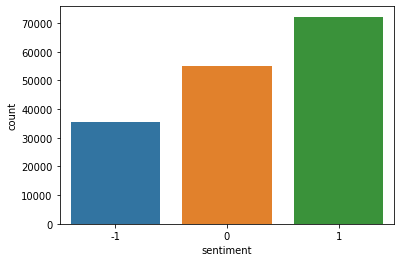

In [5]:
print('Three types of sentiments possible: ', dataset['sentiment'].unique())
sentiment_distribution = sns.countplot(x = "sentiment", data = dataset)

DATA PREPROCESSING

In [6]:
#dataset['airline_sentiment'].replace((0, 1, -1), ('neutral', 'positive', 'negative'),  inplace = True)
#dataset['airline_sentiment'].replace('None', 0, inplace = True)
dataset.sentiment.fillna(0,inplace=True)
dataset.text.fillna(' ',inplace=True)
dataset['sentiment'].value_counts()
#dataset['text'].head()

1     72250
0     55213
-1    35510
0         7
Name: sentiment, dtype: int64

In [7]:
data_text = dataset['text']
data_text.head()

0    when modi promised “minimum government maximum...
1    talk all the nonsense and continue all the dra...
2    what did just say vote for modi  welcome bjp t...
3    asking his supporters prefix chowkidar their n...
4    answer who among these the most powerful world...
Name: text, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


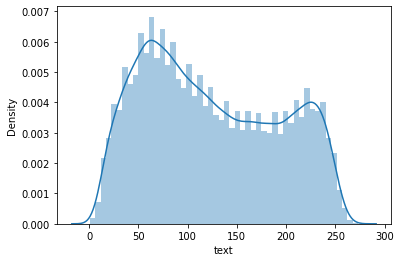

In [8]:
sns.distplot(dataset.text.str.len())
plt.show()

In [9]:
dataset.text.str.len().describe()

count    162980.000000
mean        123.630630
std          67.997988
min           1.000000
25%          66.000000
50%         113.000000
75%         182.000000
max         273.000000
Name: text, dtype: float64

In [10]:
dataset.sentiment.str.len().describe()

count    162973.000000
mean          1.217889
std           0.412813
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           2.000000
Name: sentiment, dtype: float64

In [11]:
STOPWORDS=stopwords.words('english')
STOPWORDS[:5]

['i', 'me', 'my', 'myself', 'we']

In [12]:
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data_text = data_text.apply(lambda text: cleaning_stopwords(text))
data_text.head()

0    modi promised “minimum government maximum gove...
1               talk nonsense continue drama vote modi
2    say vote modi welcome bjp told rahul main camp...
3    asking supporters prefix chowkidar names modi ...
4    answer among powerful world leader today trump...
Name: text, dtype: object

In [13]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
data_text = data_text.apply(lambda x: cleaning_punctuations(x))
data_text.head()

0    modi promised “minimum government maximum gove...
1               talk nonsense continue drama vote modi
2    say vote modi welcome bjp told rahul main camp...
3    asking supporters prefix chowkidar names modi ...
4    answer among powerful world leader today trump...
Name: text, dtype: object

In [14]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
data_text = data_text.apply(lambda x: cleaning_repeating_char(x))
data_text.head()

0    modi promised “minimum government maximum gove...
1               talk nonsense continue drama vote modi
2    say vote modi welcome bjp told rahul main camp...
3    asking supporters prefix chowkidar names modi ...
4    answer among powerful world leader today trump...
Name: text, dtype: object

In [15]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
data_text = data_text.apply(lambda x: cleaning_URLs(x))
data_text.head()

0    modi promised “minimum government maximum gove...
1               talk nonsense continue drama vote modi
2    say vote modi welcome bjp told rahul main camp...
3    asking supporters prefix chowkidar names modi ...
4    answer among powerful world leader today trump...
Name: text, dtype: object

In [16]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
data_text = data_text.apply(lambda x: cleaning_numbers(x))
data_text.head()

0    modi promised “minimum government maximum gove...
1               talk nonsense continue drama vote modi
2    say vote modi welcome bjp told rahul main camp...
3    asking supporters prefix chowkidar names modi ...
4    answer among powerful world leader today trump...
Name: text, dtype: object

In [17]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
data_text = data_text.apply(lambda x: stemming_on_text(x))
data_text.head()

0    modi promised “minimum government maximum gove...
1               talk nonsense continue drama vote modi
2    say vote modi welcome bjp told rahul main camp...
3    asking supporters prefix chowkidar names modi ...
4    answer among powerful world leader today trump...
Name: text, dtype: object

In [18]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
data_text = data_text.apply(lambda x: lemmatizer_on_text(x))
data_text.head()

0    modi promised “minimum government maximum gove...
1               talk nonsense continue drama vote modi
2    say vote modi welcome bjp told rahul main camp...
3    asking supporters prefix chowkidar names modi ...
4    answer among powerful world leader today trump...
Name: text, dtype: object

In [19]:
#def tokenize(d):
    #return word_tokenize(d)

#dataset['final_text'] = data_text.apply(tokenize)
#dataset.final_text.head()

In [20]:
#for i in range(len(dataset)):
    #dataset['final_text'][i] = " ".join(dataset['final_text'][i])

In [21]:
#X_train = dataset.final_text
X_train = data_text
X_train.head()

0    modi promised “minimum government maximum gove...
1               talk nonsense continue drama vote modi
2    say vote modi welcome bjp told rahul main camp...
3    asking supporters prefix chowkidar names modi ...
4    answer among powerful world leader today trump...
Name: text, dtype: object

In [22]:
dataset.info

<bound method DataFrame.info of                                                      text sentiment
0       when modi promised “minimum government maximum...        -1
1       talk all the nonsense and continue all the dra...         0
2       what did just say vote for modi  welcome bjp t...         1
3       asking his supporters prefix chowkidar their n...         1
4       answer who among these the most powerful world...         1
...                                                   ...       ...
162975  why these 456 crores paid neerav modi not reco...        -1
162976  dear rss terrorist payal gawar what about modi...        -1
162977  did you cover her interaction forum where she ...         0
162978  there big project came into india modi dream p...         0
162979  have you ever listen about like gurukul where ...         1

[162980 rows x 2 columns]>

MACHINE LEARNING

In [24]:
train_X, test_X, y_train, y_test = train_test_split(X_train, dataset['sentiment'], test_size=0.2, 
                                                    random_state=42, shuffle=True)

print(f'Number of training examples: {len(train_X)}')
print(f'Number of testing examples: {len(test_X)}')

Number of training examples: 130384
Number of testing examples: 32596


In [25]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(train_X)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


No. of feature_words:  500000


In [26]:
from sklearn.feature_extraction.text import CountVectorizer
c = CountVectorizer(analyzer = 'word')
#X_c = c.fit_transform(X)

In [27]:
X_train = c.fit_transform(train_X)
X_test  = c.transform(test_X)
print(f'Data Transformed.')

Data Transformed.


In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import (
    BernoulliNB,
    ComplementNB,
    MultinomialNB,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [29]:
model_params = {'random_state':50}
LR =  LogisticRegression(**model_params,solver='liblinear')
KN = KNeighborsClassifier()
SVC = SVC(**model_params)
Tree = DecisionTreeClassifier()
Forest = RandomForestClassifier(**model_params)
Ada = AdaBoostClassifier(**model_params)
Gau = GaussianNB()
BNB = BernoulliNB(alpha=2)
MNB = MultinomialNB()
CNB = ComplementNB()
MLP = MLPClassifier(**model_params)

In [30]:
y_train = y_train.astype(int)
dataset = dataset.fillna(value=np.nan)
a = BNB.fit(X_train, y_train)
b = LR.fit(X_train, y_train)
#c = KN.fit(X_train, y_train)
#d = SVC.fit(X_train, y_train)
#e = Tree.fit(X_train, y_train)
#f = Forest.fit(X_train, y_train)
#g = Ada.fit(X_train, y_train)
j = MNB.fit(X_train, y_train)
h = CNB.fit(X_train, y_train)
#i = MLP.fit(X_train, y_train)

In [31]:
y_test = y_test.astype(int)
print("Train Accuracy using BernoulliNB: ", BNB.score(X_train, y_train))
pred_BNB = a.predict(X_test)
accuracy = accuracy_score(y_test, pred_BNB)
print("Test Accuracy using BernoulliNB: ", accuracy)

print("Train Accuracy using Logistic Regression: ", LR.score(X_train, y_train))
pred_LR = b.predict(X_test)
accuracy = accuracy_score(pred_LR, y_test)
print("Accuracy using Logistic Regression: ", accuracy)

#print(KN.score(X_train, y_train))
#pred = c.predict(X_test)
#accuracy = accuracy_score(pred, y_test)
#print("Accuracy using KNeighbors: ", accuracy)

#print(SVC.score(X_train, y_train))
#pred = d.predict(X_test)
#accuracy = accuracy_score(pred, y_test)
#print("Accuracy using Support Vector Classifier: ", accuracy)

#print(Tree.score(X_train, y_train))
#pred = e.predict(X_test)
#accuracy = accuracy_score(pred, y_test)
#print("Accuracy using Decision Tree: ", accuracy)

#print(Forest.score(X_train, y_train))
#pred = f.predict(X_test)
#accuracy = accuracy_score(pred, y_test)
#print("Accuracy using Random Forest: ", accuracy)

#print(Ada.score(X_train, y_train))
#pred = g.predict(X_test)
#accuracy = accuracy_score(pred, y_test)
#print("Accuracy using AdaBoost: ", accuracy)

print("Train Accuracy using MultimonialNB: ", MNB.score(X_train, y_train))
pred_MNB = j.predict(X_test)
accuracy = accuracy_score(pred_MNB, y_test)
print("Accuracy using MultinomialNB: ", accuracy)

print("Train Accuracy using ComplementNB: ", CNB.score(X_train, y_train))
pred_CNB = h.predict(X_test)
accuracy = accuracy_score(pred_CNB, y_test)
print("Accuracy using ComplementNB: ", accuracy)

#print(MLP.score(X_train, y_train))
#pred = i.predict(X_test)
#accuracy = accuracy_score(pred, y_test)
#print("Accuracy using MLP Classifier: ", accuracy)

#print(xgb.score(X_train, y_train))
#pred = l.predict(X_test)
#accuracy = accuracy_score(pred, y_test)
#print("Accuracy using XGBClassifier: ", accuracy)

Train Accuracy using BernoulliNB:  0.7986025892747577
Test Accuracy using BernoulliNB:  0.7420542397840226
Train Accuracy using Logistic Regression:  0.9497024174745368
Accuracy using Logistic Regression:  0.9077494171063935
Train Accuracy using MultimonialNB:  0.8286752975825254
Accuracy using MultinomialNB:  0.7283715793348877
Train Accuracy using ComplementNB:  0.8551739477236471
Accuracy using ComplementNB:  0.7488035341759726


Classification Report:
----------------------
               precision    recall  f1-score   support

          -1       0.89      0.82      0.85      7179
           0       0.89      0.97      0.93     11034
           1       0.93      0.90      0.92     14383

    accuracy                           0.91     32596
   macro avg       0.90      0.90      0.90     32596
weighted avg       0.91      0.91      0.91     32596



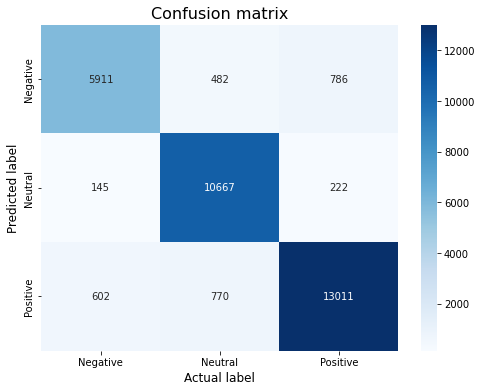

In [32]:
pred_LR = pred_LR.astype(int)
y_test = y_test.astype(int)
cr = classification_report(y_test, pred_LR)

print("Classification Report:\n----------------------\n", cr)

cm = confusion_matrix(y_test,pred_LR)


# plot confusion matrix 
plt.figure(figsize=(8,6))
sentiment_classes = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes)
plt.title('Confusion matrix', fontsize=16)
plt.xlabel('Actual label', fontsize=12)
plt.ylabel('Predicted label', fontsize=12)
plt.show()


LEXICON VADER

In [33]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [34]:
analyzer = SentimentIntensityAnalyzer()
scores = [analyzer.polarity_scores(tweet)['compound'] for tweet in dataset['text'].values.tolist()]
#len(scores) = len(dataset)
dataset['sentiment'] = scores

In [37]:
dataset.loc[dataset['sentiment'] == 0, 'final_sentiment'] = 0
dataset.loc[dataset['sentiment'] > 0, 'final_sentiment'] = 1
dataset.loc[dataset['sentiment'] < 0, 'final_sentiment'] = -1
dataset.head()

dataset['sentiment'].replace(' ', 0, inplace = True)
dataset['sentiment'] = dataset['sentiment'].astype(int)

In [39]:
from sklearn.metrics import accuracy_score

y_act = dataset['sentiment'].values
y_pred = dataset['final_sentiment'].values

accuracy_score(y_act, y_pred)

0.20258927475763897

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
----------------------
               precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00         0
         0.0       1.00      0.20      0.34    162980
         1.0       0.00      0.00      0.00         0

    accuracy                           0.20    162980
   macro avg       0.33      0.07      0.11    162980
weighted avg       1.00      0.20      0.34    162980



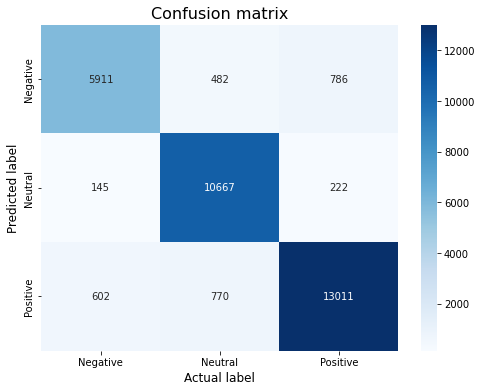

In [40]:
cr = classification_report(y_act, y_pred)

print("Classification Report:\n----------------------\n", cr)

cm = confusion_matrix(y_test,pred_LR)


# plot confusion matrix 
plt.figure(figsize=(8,6))
sentiment_classes = ['Negative', 'Neutral', 'Positive']
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes)
plt.title('Confusion matrix', fontsize=16)
plt.xlabel('Actual label', fontsize=12)
plt.ylabel('Predicted label', fontsize=12)
plt.show()
